In [1]:
import pandas as pd

# Executive Summary 
(Business Audience)

## Objective
We were given a set of news articles and aim a identify efficient and sophisticated way to find words which are trending. To accomplish this we need to both
- Find trends within the sample dataset provided
- Demonstrate how the approach can be applied & scaled to larger datasets

## Data
- Covers ca 8000 news messages over 3 days in 16 Languages 
- After removing duplicate news and test and system messages, the remaining news are about only 1100 unique English articles

## Approach, Assumptions, Limitations
### Defining 'trending words'
Exceptional increase of mentions of a word or sequence of words in a consistent context. Main characteristics are:
- exceptional increase of mentions with respect to the overall mentions of the word AND
- some level of consistent context for those mentions



## Results
### Trending words found in the data

### Approach to trending developed
As the data is inherently unsupervised, we have built a model that can use statistical metrics for stationarity and topic homogeneity and does not rely on training data. However, we have labaled a small dataset for evaluaton purposes

================================= END EXECUTIVE SUMMARY =================================

## Technical Summary
(Technical ie Data Science Audience)

### Summary of evaluation approach
Aim is to show time series with trending words or word-ngrams. We interpret this as follows:
 1. high internal similarity (ie fairly homogeneous group of items, ie topic-like behavior) t-test on signifant difference in cosine similarity 
 2. exhibit non-stationarity (ie there is a marked change in behavior for those words - dickey fuller test on stationarity
 
To evaluate the results, there is no actual ground truth, the approach is tested against a small number of manually labelled ground truth of 
- top 50 most frequent words in the whole dataset (total count)
- top 30 highest spiking words in the dataset (highest mentions within a 2hr rolling period)

### High level description of pipeline
- Preprocessing: Some clean up done based on EDA (see steps on pre-processing below)
- Transformation: In order to identify trends, have considered basic counts, tf-idf and bucketed into 5min time_intervals for consistent time
- Evaluation:
    - Tests for internal similarity of a trending word: t-test performed between the overall cosine similary of all article pairs in the data vs all articles where the word is mention in their title
    - Tests for stationarity: Augmented Dickey Fuller test, tests whether there are momentum like trends in the series (ie unit roots) tests applied on a rolling time series of titlle mentions, either via TfIdf, Counts



## Detail on pipeline steps
|#|Stage|Step|Description|Outcome|Alternatives Considered|Relevant code|
|---|---|----|-----------|-------|-----------------------|-------------|
|1|Preprocessing|Remove by starting text|Articles starting with "Top news" are summaries so will distort trend statistics. Articles starting with "Test" are admin| 1010 articles removed | - | rm_rows_starting|
|2|Preprocessing|Remove by type of event|Event type "delete" removed, Story type "D" are service alerts and notify status of feed, hence both noth relevant | 1120 articles removed | - | rm_values_by_flag|
|3|Preprocessing|Merge Article Body| ACCUMULATED_STORY_TEXT & TAKE_TEXT seem to be mutually completing so merged and separete fields were dropped, minor clean up done | - | - | mrg_cols, clean_txt|
|4|Preprocessing|Group by unique ID| PNAC field provides unique IDs for all articles | ca 3600 duplicates removed | Use 'Unique_story_index' however both approaches roughly halve the article population |group_by_id|
|5|Preprocessing|Restict to English| Use only English language articles | ca 1200 duplicates remain | Using all languages, however, results should be independent of language and English lends itself to easier interpretation |-|
|6|Modelling|Clean up| Some removal of punctuation,etc | - | - |-|
|7|Modelling|Word vectorization| Tokenization and use of TfIdf of simple counts to formulate word time series | - | 1. NER can help remove some of the obviously repetitive and generic words & mentions of numbers \n 2. Lemmatisation can help aggregate similar words \n 3. Word/Sentence Embeddings for finer semantic attribution |build_time_series, Vectorizer, spacy_tokenizer|
|8|Modelling|Interval bucketing| Results bucketed further into 5min minute interval for consistent time units. Aggregation can be done either as a max or a sum frequency, where sum is prefered for counts and amx for TfIdf | - | Different time periods can be experimented with for optimal results |build_time_series, TimeBuckets|
|9|Prediction|Prediction| Positive labels are given to words which cannot reject the Dickey Fuller Test of Unit root and reject a T-test of similar correlation distributions | - | Different time periods can be experimented with for optimal results |TimeBuckets|
|10|Evaluation|Accuracy| Measure accuracy aganst a small number of hand labeled values from the most frequent words used | - | One can expand the analysis to the use of precision and recall for this |TimeBuckets|



## Discussion of choices
### The Dickey Fuller test 
- The benefit of using the test is that it gives a statistical metric for aut
- The null hypothesis there is the presence of a unit root, ie each event influences the next one. However, here we are performing the test on rolling sums of wrod mentions. Therefore the accuracy of the test is somewhat impaired. The rolling sums approach is used as in most cases the data is extremely inoisy without some level of smoothing
- Some alternatives to the Dickey-Fuller test that can be appropriate here are 
     - the Chow test for structural breaks. However, it requires a known point where the break might be happening
     - T-test between distributions, eg long term distribtion vs some rolling distribution. However, it requires normal distributions of the underlyings while those are Poisson distributed here
     
### The T-test use for correlation distributions. 
- Helpful as provides a statistical metric
- Concerns around the assumption of normality of the underlying. Oftern correlation distributions exhibit beta distribution which makes the test potentially invalid
    
### On Embeddings and Transformer architectures (eg BERT)
There is still a lot of use that can be had from these. For instance:
- Word level embeddings can help find semantically meaningful trends. They can be used to find words with high cosine similarity (ie >95%) to identify synonyms and essentially equivalent words to improve the quality of aggregated individual words, eg cases like "America", "USA" , "the US" , etc will collase into one instance and help significantly in finding trends without using explainability
- Sentence level embeddings via eg BERT can be used to assess how homogeneous are collections of articles assigned to a trend. Similar to the solution here where cosine similarity of tf-idf on article bodies is leveraged, one can use sentence level embeddings for artcile titles and compare those instead or as a reinforcing indicator
- Sentence level embeddings can be used to stop article title duplication. Again, by observing high cosine similarity
- One shortcoming of sentence level embeddings could be some loss of interpretability. If used to build classifiers for trends (eg based on some weak supervision or small number of hand labeled examples) explainability might be lost in the inability to assign the sentence to a specific word which triggered the label

In [50]:
import sys
sys.path
sys.path.append('/Users/md/Downloads/trending_topics/env-trending/lib/python3.7/site-packages')

In [3]:
%load_ext autoreload

In [28]:
%autoreload 2
import trending_preprocess as pp
import trending_modelling as md

In [40]:
df=pd.read_csv('rna002_RTRS_2017_11_29.csv',engine='python', encoding='utf-8',error_bad_lines=False).fillna('')

Skipping line 8132: unexpected end of data


In [41]:
pp.summary_stats(df, max_smpl=5)

,Unique,# Missing,# Zeros,Available,% Available,Types,Sample
DATE,3,0,0,8130,100.0,object,"[2013-06-01, 2013-06-02, 2013-06-03]"
TIME,7012,0,0,8130,100.0,object,"[08:00:00.382, 04:00:00.708, 12:45:21.355, 02:54:52.433, 09:06:48.014]"
UNIQUE_STORY_INDEX,3707,0,0,8130,100.0,object,"[20130602123706nL5N0EE0EB, 20130603031355nL3N0EF0O0, 20130603041856nL1N0EF02C, 20130601080000nEAP31Z1DC, 20130502090000nEAP31Z2F0]"
EVENT_TYPE,5,0,0,8130,100.0,object,"[STORY_TAKE_OVERWRITE, ALERT, HEADLINE, DELETE, STORY_TAKE_APPEND]"
PNAC,2797,0,0,8130,100.0,object,"[nEAP51Z100, nL3N0EE06B, nL3N0EF04S, nEMS06G9EU, nL5N0ED0BJ]"
STORY_DATE_TIME,3185,0,0,8130,100.0,object,"[2013-06-01 00:59:13, 2013-05-01 06:00:00, 2013-06-02 12:35:11, 2013-06-01 15:59:21, 2013-06-03 04:53:25]"
TAKE_DATE_TIME,3432,3579,0,4551,56.0,object,"[2013-06-02 21:11:16, 2013-06-01 16:46:23, 2013-06-01 05:51:21, 2013-06-03 04:43:07, 2013-06-02 20:51:02]"
HEADLINE_ALERT_TEXT,3262,955,0,7175,88.0,object,"[《美國重要政經日程》--6月3日, LEAD 1-Les violences ont fait plus de 1.000 morts en Irak en mai, INDICATORS - United Arab Emirates - June 2, 全球金融：美聯儲副主席葉倫稱大銀行所需資本可能高於巴塞爾標準, BUZZ-USD/TWD holds onto its familiar range for now]"
ACCUMULATED_STORY_TEXT,360,7755,0,375,5.0,object,[ Jun 3 (Reuters)-Below are the details of India Certificates of Deposit dealt in the \nprimary & secondary market for May 2013. (10 million = 1 crore) \n----------------------------------------------------------------------------------------------- \nISSUER INVESTOR MATURITY RATING DEALT VOLUME TRADED \n YTM(%) IN MLNS DATE \n-------------------------------------------------...
TAKE_TEXT,3427,4551,0,3579,44.0,object,"[Test, Please Ignore -- APAC -- 06/02 08:30, إيران الشيعية الأسد. \n وقال إيال ""حتى وإن تم القضاء على المعارضة فإن التخلي عنها لن \nيصب في مصلحة معظم الدول العربية لأنها تريد أن يكون لديها أداة \nلتواصل الضغط على الأسد وإيران."" \n وهناك كثير من المصالح الأخرى المتعارضة تجعل من الصعب توقع \nكيفية إيجاد حل دبلوماسي رغم الجهود الأمريكية والروسية الرامية \nلعقد مؤتمر سلام في جنيف خلال الأسابيع المقبلة. \n وتحولت الانتفاضة الشعبية إلى صراع متعدد الأوجه تواجه فيه \nالأقليات الدينية في سو..."


In [319]:
select_cols=['DATE', 'TIME', 'UNIQUE_STORY_INDEX', 'EVENT_TYPE', 'PNAC',
               'STORY_DATE_TIME', 'TAKE_DATE_TIME', 'HEADLINE_ALERT_TEXT', 
                 'ART_BODY_MERGED','NAMED_ITEMS', 
                  'TOPICS', 'RELATED_RICS', 'LANGUAGE']

In [318]:
df_clean=df.pipe(pp.rm_rows_starting,'HEADLINE_ALERT_TEXT',['Test, Please Ignore','*TOP NEWS*']) \
        .pipe(pp.rm_values_by_flag,'EVENT_TYPE','DELETE') \
        .pipe(pp.rm_values_by_flag,'STORY_TYPE','D') \
        .pipe(pp.mrg_cols,['ACCUMULATED_STORY_TEXT','TAKE_TEXT'],'ART_BODY_MERGED') \
        .pipe(pp.clean_txt,'ART_BODY_MERGED') \
        .pipe(pp.group_by_id,select_cols=select_cols, sort_by='ART_BODY_MERGED',group_by='PNAC')

        
print(df_clean.shape)
df_unq_en=df_clean[df_clean.LANGUAGE=='EN']
print(df_unq_en.shape)
    

(2394, 13)
(1034, 13)


In [113]:
pp.summary_stats(df_unq_en)

,Unique,# Missing,# Zeros,Available,% Available,Types,Sample
PNAC,1034,0,0,1034,100.0,object,"[nISS682472, nISS703978, nL3N0EF0GW, nFit659734, nL3N0ED068, nL5N0E93ZH, nL3N0ED07L, nEMS0C9P8K, nL3N0EF0W4, nL3N0EF0J9]"
DATE,3,0,0,1034,100.0,object,"[2013-06-02, 2013-06-03, 2013-06-01]"
TIME,1034,0,0,1034,100.0,object,"[04:59:49.306, 09:19:30.230, 00:32:48.410, 23:44:28.347, 20:11:49.477, 02:54:50.447, 00:21:19.113, 22:59:49.422, 02:36:30.002, 04:54:20.204]"
UNIQUE_STORY_INDEX,1034,0,0,1034,100.0,object,"[20130603010739nL3N0EF07N, 20130603011843nL3N0EF060, 20130601013030nEMS0639SO, 20130603005755nIFRc99FTq, 20130602232648nL3N0EE0JX, 20130602000547nL5N0ED0QL, 20130602011111nL3N0EE00E, 20130601034721nL2N0EA1TV, 20130603022013nL3N0EF0CX, 20130601023041nEMS065F18]"
EVENT_TYPE,4,0,0,1034,100.0,object,"[STORY_TAKE_APPEND, STORY_TAKE_OVERWRITE, ALERT, HEADLINE]"
STORY_DATE_TIME,990,0,0,1034,100.0,object,"[2013-06-03 04:23:12, 2013-06-02 20:46:30, 2013-06-02 08:00:10, 2013-06-01 01:00:00, 2013-06-02 17:16:35, 2013-06-03 01:59:11, 2013-06-01 11:30:05, 2013-06-01 12:56:48, 2013-06-02 22:55:03, 2013-06-03 04:14:09]"
TAKE_DATE_TIME,755,247,0,787,76.0,object,"[2013-06-03 04:01:00, 2013-06-03 01:47:16, 2013-06-03 02:31:05, 2013-06-03 03:43:55, 2013-06-02 13:07:15, 2013-06-01 22:26:32, 2013-06-02 20:35:34, 2013-06-02 11:39:46, 2013-06-01 14:03:04, 2013-06-02 11:36:56]"
HEADLINE_ALERT_TEXT,989,2,0,1032,100.0,object,"[Bangladesh inter bank forex, interest rates, DIARY-U.S. refinery operations-Flint Hills, Exxon, BP, Valero, Trade row dims IATA's brighter airline business mood , Test please ignore from ENM Global, UPDATE 1-This is a test from Reuters Singapore, please ignore, MARKET EYE-USD/INR seen starting higher; shares eyed for cues, UPDATE 1-Soccer-Argentine championship results and standings, Rugby-Highlanders use early onslaught to demolish Blues , Illinois bill to legalize gay marriage stalls, TAB..."
NAMED_ITEMS,112,862,0,172,17.0,object,"[CME/VOLS, CH/EQUITY, .HK .SS, MET/L, CME/STXSI, CME/STXPL, REF/US, CME/STXPA, ROHDE/, DATA/]"
TOPICS,797,0,0,1034,100.0,object,"[ID MY WEU ASEAN ASIA EMRG SFTS COF LEN RTRS REP COFARA COFROB EUROP COM AGRI, STX HOT FINS BISV BSVC INVS FIN JP ASIA CMPNY TRAD WHO INDS ISER LEN RTRS, AU ASIA LIF OBIT MSIC SHOW US HEA CYCS CCOS MDIA AMERS GEN SOCI PRO ENT LEN RTRS, AU ASIA CMPNY MRCH HECA PHMR DRU LEN RTRS, REGS FUND BANK INVB INVM INVD BNK FIN EMRG ID CH DE HK JP FR US GB CMPNY FINS BISV BSVC INVS BACT ASEAN ASIA WEU EUROP CEEU EZC CN AMERS LEN RTRS, PIA DIP HRGT POL TRAN DISP YE US SA ASIA MEAST VIO WASH BOMB SECUR INS..."


Aim is to show time series of word-ngrams which have both 
 1. high internal similarity (ie fairly homogeneous group of items, ie topic-like behavior) t-test on signifant difference in cosine similarity 
 2. exhibit non-stationarity (ie there is a marked change in behavior for those words - dickey fuller test on stationarity
 
To evaluate the results, there is no actual ground truth, the approach is tested against a small number of manually labelled ground truth of 
- top 50 most frequent words in the whole dataset (total count)
- top 30 highest spiking words in the dataset (highest mentions within a 2hr period)

In [32]:
df_unq_en

,PNAC,DATE,TIME,UNIQUE_STORY_INDEX,EVENT_TYPE,STORY_DATE_TIME,TAKE_DATE_TIME,HEADLINE_ALERT_TEXT,ART_BODY_MERGED,NAMED_ITEMS,TOPICS,RELATED_RICS,LANGUAGE
0,nASA05F0P,2013-06-01,01:07:57.659,20130531230534nASA05F0P,STORY_TAKE_OVERWRITE,2013-05-31 23:05:34,,BRIEF-Linn Energy LinnCo and Berry Petroleum Company provide update on merger,May 31 (Reuters) - Linn Energy <LINE.O>: * LinnCo and Berry Petroleum Company provide update on merger * Parties now anticipate the shareholder and unitholder meetings to occur in the third quarter of 2013 * Source text for Eikon [ID:nGNXUXXKIa] * Further company coverage [LINE.O] ((Bangalore Newsroom; +1 646 223 8780)),,US AMERS BUS BSUP CMSS INDS ISER CMPNY ENR ENER EXPL OILG BLR LEN RTRS,LINE.O BRY.N LNCO.O,EN
1,nASA05F0W,2013-06-01,00:00:00.704,20130601000000nASA05F0W,ALERT,2013-06-01 00:00:00,2013-06-01 00:00:00,MERCATOR MINERALS ANNOUNCES SENIOR MANAGEMENT CHANGES,,,MNGISS BACT MET BMAT MIN MINE MTAL CMPNY CA AMERS MEMI BLR LEN RTRS,ML.TO,EN
2,nASA05F0X,2013-06-01,00:00:01.112,20130601000000nASA05F0X,ALERT,2013-06-01 00:00:00,2013-06-01 00:00:00,MERCATOR MINERALS ANNOUNCES SENIOR MANAGEMENT CHANGES,,,MNGISS BACT MET BMAT MIN MINE MTAL CMPNY CA AMERS MEMI BLR LEN RTRS,ML.TO,EN
3,nASA05F0Y,2013-06-01,00:00:15.120,20130601000014nASA05F0Y,ALERT,2013-06-01 00:00:14,2013-06-01 00:00:14,"STAR BUFFET, INC. SELLS REAL ESTATE",,,US AMERS CMPNY FIN FINS CAFE CCOS CYCS ENTS MRG BACT DEAL1 RESF RES BLR LEN RTRS,STRZ.PK,EN
4,nASA05F0Z,2013-06-01,00:16:45.555,20130601001220nASA05F0Z,STORY_TAKE_OVERWRITE,2013-06-01 00:12:20,,BRIEF-Anheuser Busch Inbev says tender offer for all outstanding Grupo Modelo shares expires,"May 31 (Reuters) - Anheuser Busch Inbev SA <ABI.BR>: * Announces expiration of tender offer for all outstanding Grupo Modelo shares * As of expiration of tender offer, a preliminary total of 1.97 billion shares had been tendered * Source text for Eikon [ID:nPnNY24380] * Further company coverage [ABI.BR] ((Bangalore Newsroom; +1 646 223 8780))",,BEV BEVS FOBE NCYC BEER BE EUROP EZC WEU CMPNY US AMERS DBT USC CDM CORPD HYD LOA BLR LEN RTRS MRG BACT DEAL1 EMRG MX LATAM,ABI.BR GMODELOC.MX STZ.N,EN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,nWNBS0041D,2013-06-03,00:38:22.758,20130603003822nWNBS0041D,ALERT,2013-06-03 00:38:22,2013-06-03 00:38:22,MOUNT MAGNET SOUTH NL - TRADING HALT <MUM.AX>,,,AU ASIA CMPNY GDM BMAT MIN MINE MTAL PREC LEN RTRS,MUM.AX,EN
2388,nWNBS0041E,2013-06-03,03:22:13.184,20130603031052nWNBS0041E,STORY_TAKE_OVERWRITE,2013-06-03 03:10:52,,"BRIEF-India's CRISIL open offer price set at 1,210 rupees/share - issue manager","June 3 (Reuters) - CRISIL Ltd <CRSL.NS>: * Open offer for acquisition of up to 15.7 million shares of Crisil - manager to the offer * Offer by McGraw Hill-Asian Holdings with S&P India, Standard & Poor's International, McGraw Hill Financial - manager to the offer * Offer price is 1,210 rupees per share - manager to the offer * Source text: http://link.reuters.com/mur58t * Further company coverage [CRSL.NS] ((Bangalore Newsroom; +91 80 6749 1130))",,BLR IN ASIA EMRG INVI BISV FINS INVS CMPNY BUS BSUP CMSS INDS ISER LEN RTRS READ CCOS CYCS MDIA PUB US AMERS MRG BACT DEAL1,CRSL.NS MHFI.N,EN
2389,nWNBS0041F,2013-06-03,04:49:54.866,20130603043217nWNBS0041F,STORY_TAKE_OVERWRITE,2013-06-03 04:32:17,,India's Bajaj Auto May sales down 4 pct y/y,"MUMBAI, June 3 (Reuters) - Bajaj Auto Ltd's <BAJA.NS> vehicle sales in May: May 2013 May 2012 pct change TOTAL SALES 339,348 352,219 -4 MOTORCYCLE SALES 304,780 321,922 -5 EXPORTS 111,835 130,573 -14 NOTE: Bajaj Auto is an Indian motorcycle manufacturer and the world's largest motorised three-wheeled rickshaw maker. (Reporting by Aditi Shah; Editing by Prateek Chatterjee) ((aditi.shah@thomsonreuters...",,BLR IN ASIA EMRG CARM AUTO CYCS CMPNY RES BACT AUT LEN RTRS PART,BAJA.NS,EN
2390,nX312D69VW,2013-06-03,03:00:06.240,20130603030006nX312D69VW,STORY_TAKE_OVERWRITE,2013-06-03 03:00:06,,TABLE-Japan Exchange Group <8697.T

In [211]:
df_agg, df_flat, pipe=md.build_word_frequencies(df_unq_en,'HEADLINE_ALERT_TEXT','count',5, ngram=4, min_df=5)
df_agg.shape

(436, 491)

In [210]:
_, df_flat_tfidf,_=md.build_word_frequencies(df_unq_en,'ART_BODY_MERGED','tfidf',5, ngram=4, min_df=5)

In [166]:
%matplotlib inline

In [269]:
from sklearn.metrics.pairwise import cosine_similarity

cos_res_full=cosine_similarity(df_flat_tfidf,  df_flat_tfidf)
cos_dist_full=cos_res[np.triu_indices_from(cos_res,k=1)]

def t_test_dist(df_emb,df_idx,instance,cos_dist_full):
    # Taking article index from the word dataframe and the tfidf embedding from the "article body" one
    df_instance=df_emb[df_idx[instance]!=0]
    cos_res_instance=cosine_similarity(df_instance,  df_instance)
    cos_dist_instance=cos_res_instance[np.triu_indices_from(cos_res_instance,k=1)]
    cos_dist_inst_rept=np.random.choice(cos_dist_instance, len(cos_dist_full), replace=True)
    t2, p2 = stats.ttest_ind(cos_dist_full,cos_dist_inst_rept)
    return p2

In [178]:
from random import choice, sample
cos_dist_inst_rept=np.random.choice(cos_dist_instance, len(cos_dist_full), replace=True)

In [179]:
t2, p2 = stats.ttest_ind(cos_dist_full,cos_dist_inst_rept)

In [180]:
p2

0.0

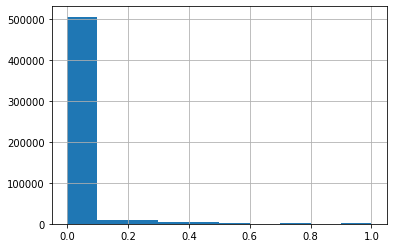

In [167]:
pd.Series(cos_res[np.triu_indices_from(cos_res,k=1)]).hist()

In [213]:
top50_cnt=df_agg.sum().fillna(0).sort_values(ascending=False).head(50)

In [214]:
top50_cnt

term
update                                139
june                                   64
power                                  63
buzz                                   55
soccer                                 53
india                                  48
3                                      47
says                                   43
pct                                    42
china                                  41
results                                40
table                                  37
june 3                                 34
usd                                    33
american                               32
north                                  32
north american                         30
moody                                  29
u.s                                    29
stocks                                 28
american power transmission outage     28
american power transmission            28
power transmission outage              28
power transmission outage upd

In [153]:
top50_spk=df_agg.rolling(24).sum().fillna(0).max().sort_values(ascending=False).head(30)

In [200]:
top50_spk

term
india             23.0
moody             21.0
update            18.0
buzz              18.0
3                 18.0
california        17.0
table             16.0
june              16.0
research          15.0
01                15.0
rating            15.0
pct               14.0
power             14.0
soccer            14.0
jun               14.0
bonds             14.0
research alert    13.0
alert             13.0
jun 01            13.0
moody assigns     12.0
price             12.0
market            12.0
june 3            12.0
assigns           12.0
shares            11.0
pmi               11.0
usd               11.0
price target      11.0
china             11.0
target            11.0
dtype: float64

0.0

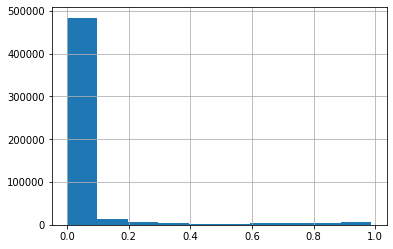

In [270]:
t_test_dist(df_flat_tfidf,df_flat,'india',cos_dist_full)

india 0.4086693995554007 0.0
update 0.10652255639730601 0.0
buzz 0.28332374693314166 0.0
3 0.9986727039090991 0.0
table 0.9987010019714724 0.0
june 0.7232245078162852 0.0
research 1.0 0.0
rating 0.15153526367842318 0.0
pct 0.7076859998553291 0.0
bonds 0.16429434109228425 0.0
research alert 0.99527871742719 0.0
alert 0.9990466493647229 0.0
moody assigns 0.10569465174438136 0.0
price 0.9960780512270128 0.0
market 0.9961057903794736 0.0
june 3 0.9757233354842275 0.0
assigns 0.11588630976924857 0.0
shares 0.6252013052360217 0.0
pmi 0.1001197577628144 0.0
usd 0.5237527345428948 0.0
price target 1.0 0.0
china 0.7846418622614622 0.0
target 1.0 0.0


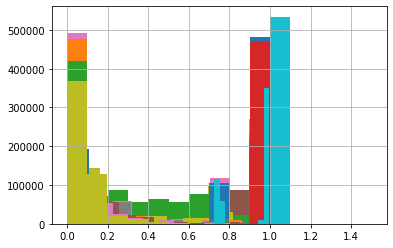

In [295]:
res_spk_cnt=[]
for wrd in list(top50_spk.index):
    adf_res=adfuller(df_agg[wrd].rolling(24).sum().fillna(0), autolag='AIC')[1]
    t_res=t_test_dist(df_flat_tfidf,df_flat,wrd,cos_dist_full)
    if (t_res<0.05) & (adf_res>.05):
        print(wrd,adf_res,t_res)
        res_spk_cnt.append(wrd)

In [196]:
df_flat_tfidf.shape

(1034, 11637)

update 0.12893567574595932 0.0
june 0.7838238093758945 0.0
buzz 0.5193924338721067 0.0
soccer 0.1110818842476497 0.0
india 0.05176249377436882 0.0
3 0.9977498631815545 0.0
pct 0.6350066978724415 0.0
china 0.6882967605534458 0.0
table 0.8544591419790319 0.0
june 3 0.9860365220410655 0.0
usd 0.7305185219437078 0.0
stocks 0.18212410057299777 0.0
market 0.9868136517351502 0.0
shares 0.9536524416797709 0.0


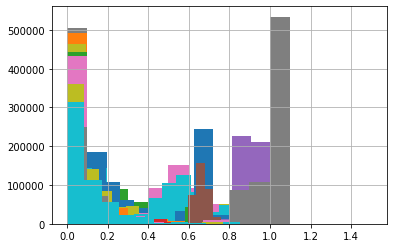

In [286]:
res_top_cnt=[]
for wrd in list(top50_cnt.index):
    
    adf_res=adfuller(df_agg[wrd].rolling(12).sum().fillna(0), autolag='AIC')[1]
    t_res=t_test_dist(df_flat_tfidf,df_flat,wrd,cos_dist_full)
    if (t_res<0.05) & (adf_res>0.05):
        print(wrd,adf_res,t_res)
        res_top_cnt.append(wrd)

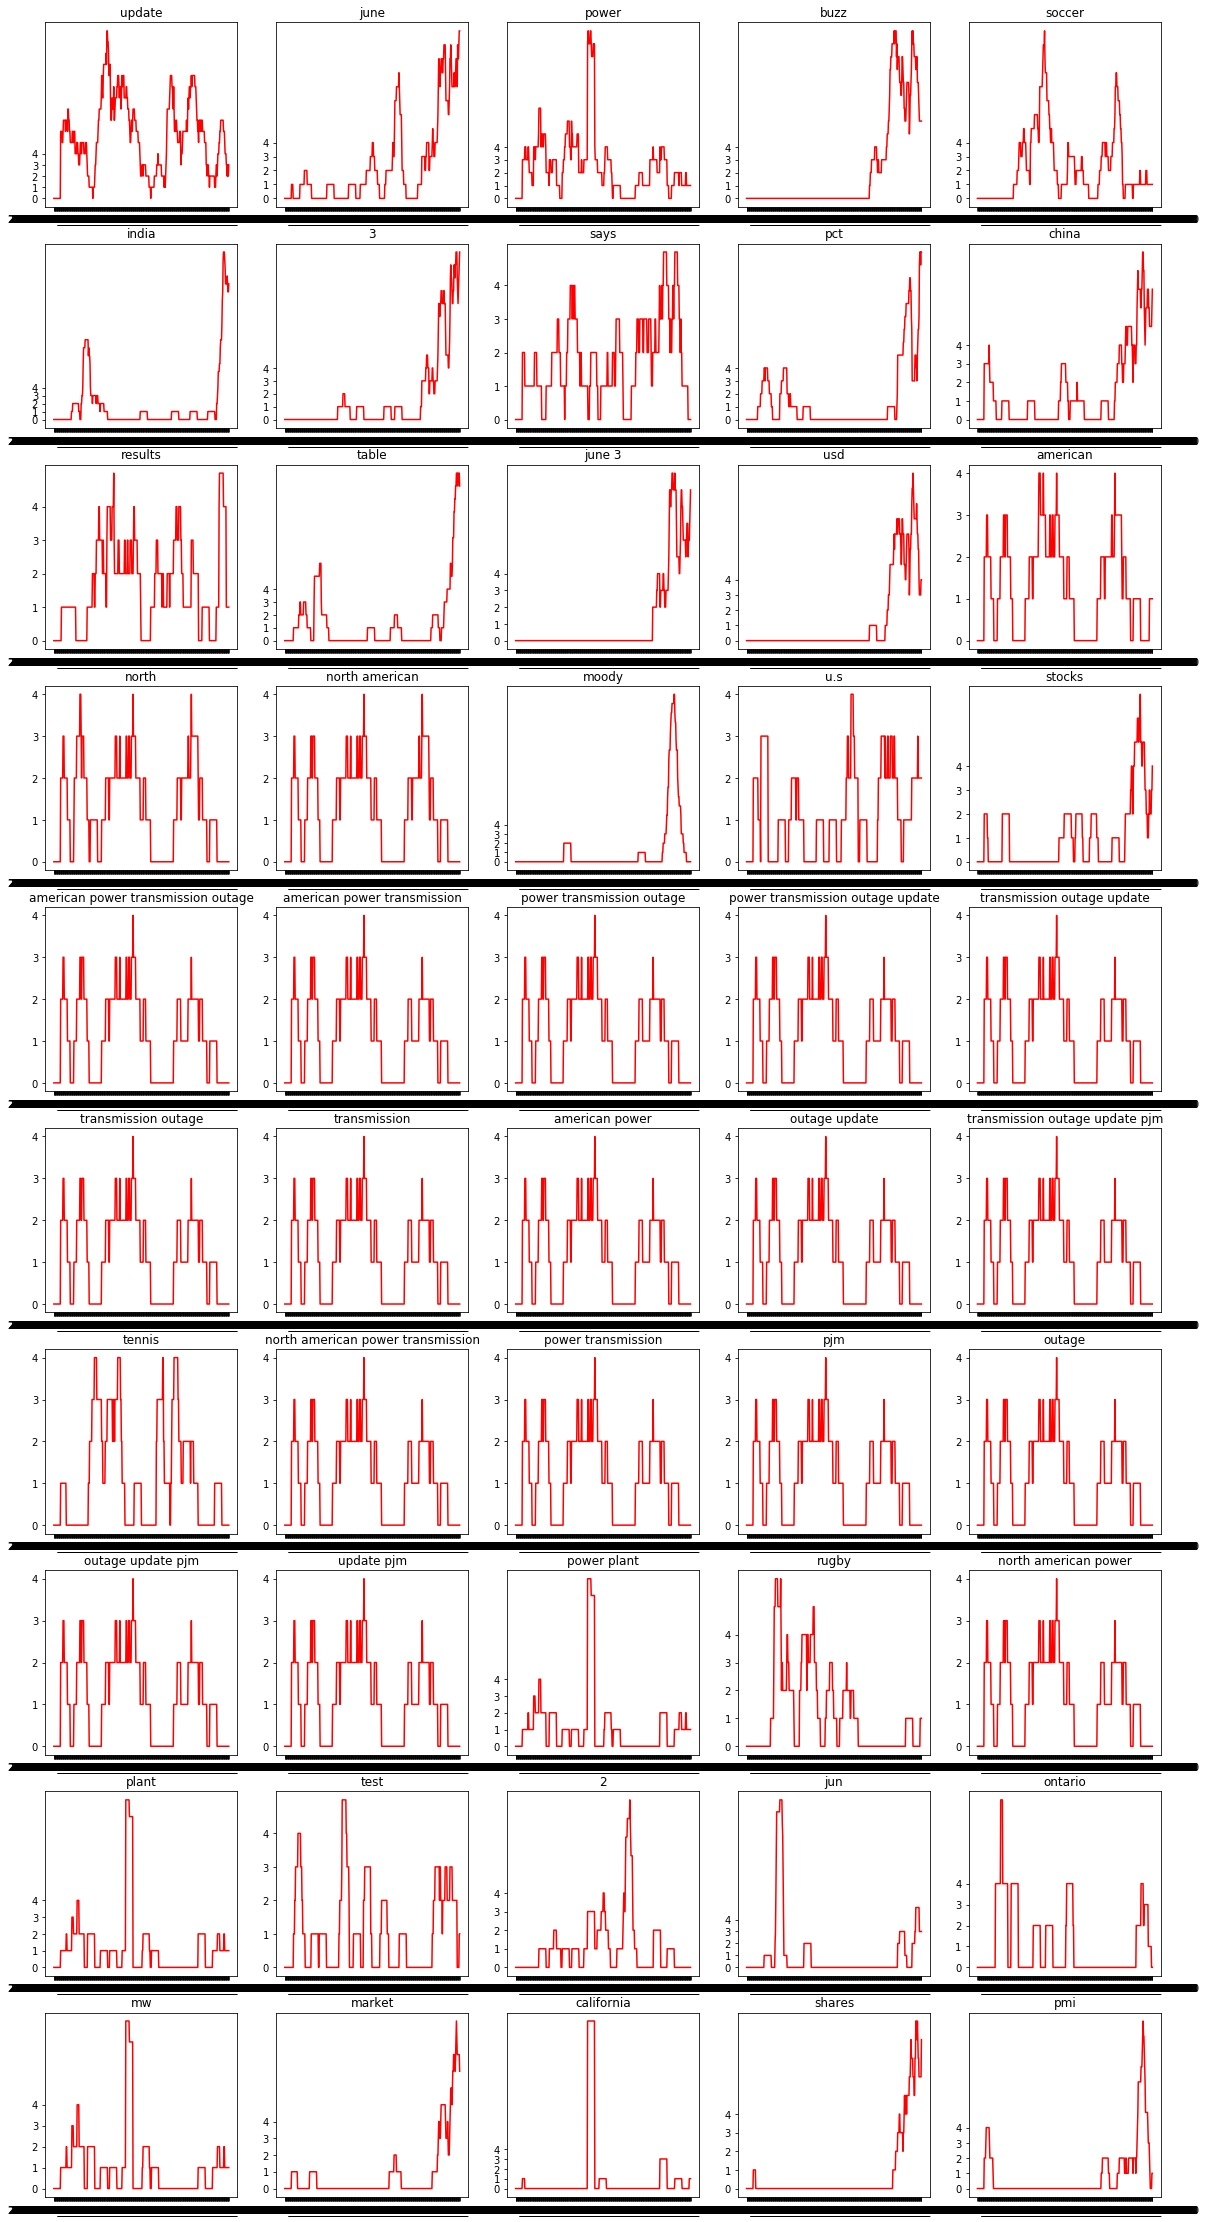

In [272]:
pp.make_plt(df_agg.rolling(18).sum().fillna(0),list(top50_cnt.index),res_top_cnt)

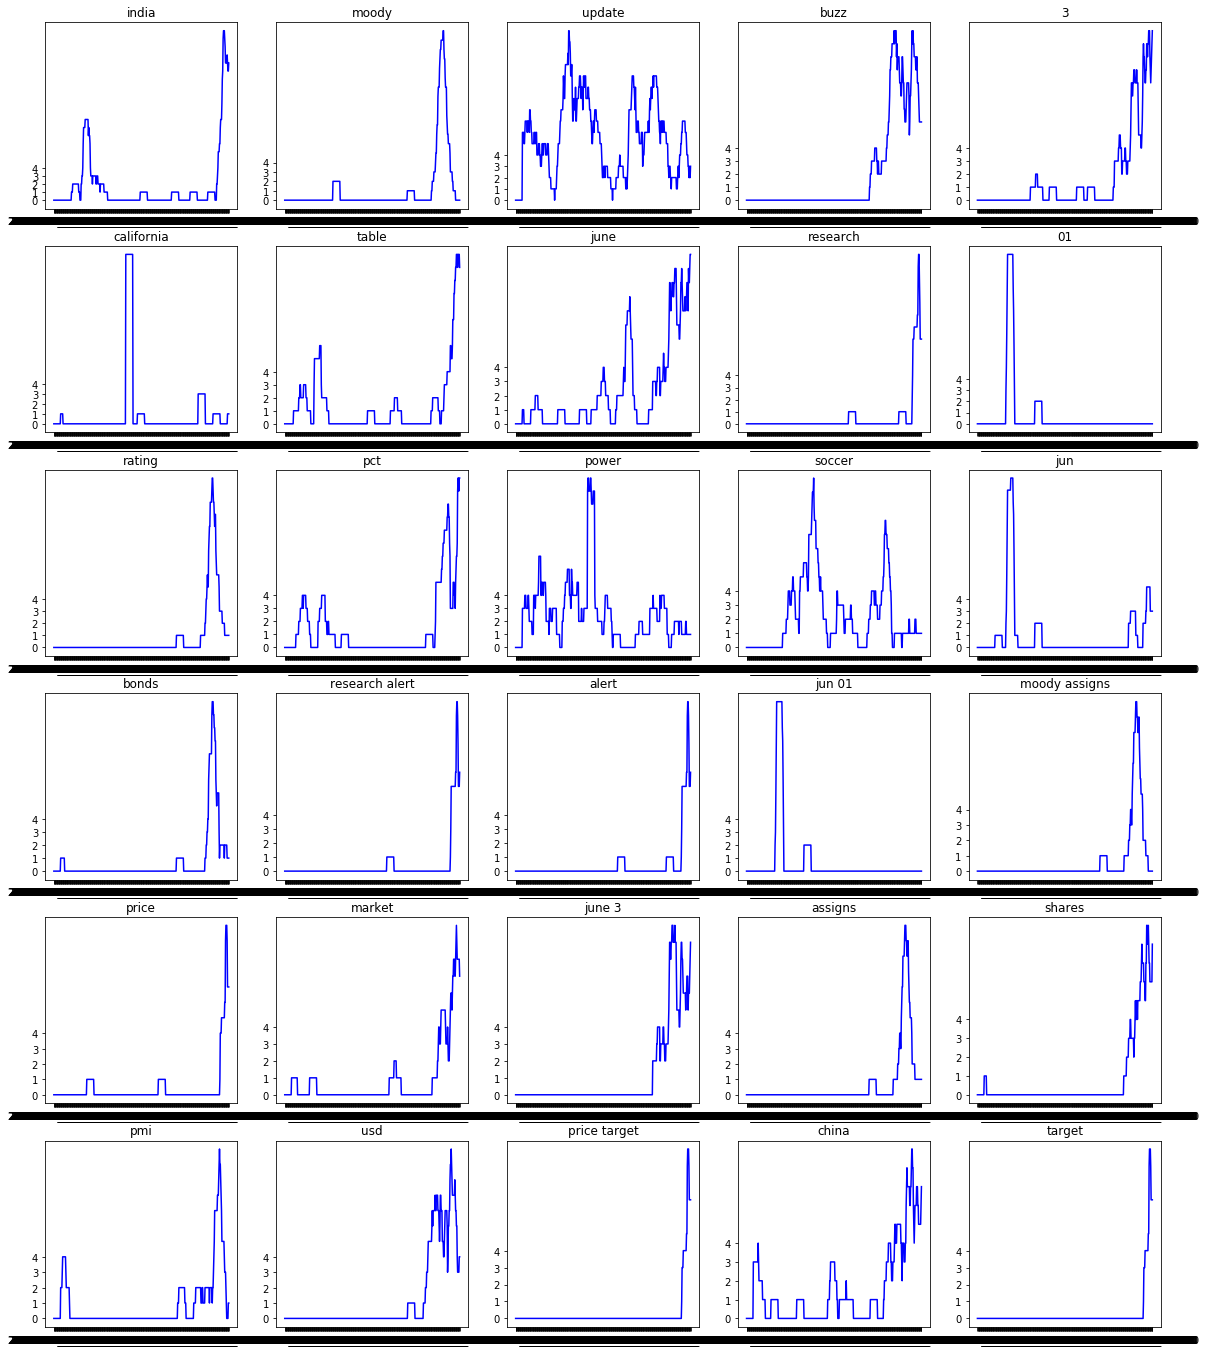

In [273]:
pp.make_plt(df_agg.rolling(18).sum().fillna(0),list(top50_spk.index),[])

In [284]:
b=[['india', 1],
 ['moody', 1],
 ['update', 0],
 ['buzz', 1],
 ['3',1],
 ['california', 0],
 ['table', 1],
 ['june', 1],
 ['research', 1],
 ['01', 0],
 ['rating', 1],
 ['pct', 1],
 ['power', 0],
 ['soccer', 0],
 ['jun', 0],
 ['bonds', 1],
 ['research alert', 1],
 ['alert', 1],
 ['jun 01', 0],
 ['moody assigns', 1],
 ['price', 1],
 ['market', 1],
 ['june 3', 1],
 ['assigns', 1],
 ['shares', 1],
 ['pmi', 1],
 ['usd', 1],
 ['price target', 1],
 ['china', 0],
 ['target', 1]]

In [296]:
df_spk_true=pd.DataFrame(b, columns=['Topic','Label'])

In [298]:
df_spk_true

,Topic,Label
0,india,1
1,moody,1
2,update,0
3,buzz,1
4,3,1
5,california,0
6,table,1
7,june,1
8,research,1
9,01,0


In [294]:
df_pred=pd.DataFrame(list(top50_cnt.index), columns=['Topic'])
df_pred['Label']=0
df_pred['Label']=df_pred.apply(lambda x: 1 if x['Topic'] in res_top_cnt else 0, axis=1)

from sklearn.metrics import accuracy_score

accuracy_score(df_top_true['Label'],df_pred['Label'])


0.66

In [306]:
df_pred_spk=pd.DataFrame(list(top50_spk.index), columns=['Topic'])
df_pred_spk['Label']=0
df_pred_spk['Label']=df_pred_spk.apply(lambda x: 1 if x['Topic'] in res_spk_cnt else 0, axis=1)

from sklearn.metrics import accuracy_score

accuracy_score(df_spk_true['Label'],df_pred_spk['Label'])



0.9

In [299]:
df_spk_true['pred']=df_pred_spk['Label']

In [305]:
top50_cnt

term
update                                139
june                                   64
power                                  63
buzz                                   55
soccer                                 53
india                                  48
3                                      47
says                                   43
pct                                    42
china                                  41
results                                40
table                                  37
june 3                                 34
usd                                    33
american                               32
north                                  32
north american                         30
moody                                  29
u.s                                    29
stocks                                 28
american power transmission outage     28
american power transmission            28
power transmission outage              28
power transmission outage upd

In [292]:
a=[['update', 0],
['june', 1],
['power', 0],
['buzz', 1],
['soccer', 0],
['india', 1],
['3', 1],
['says', 0],
['pct', 0],
['china',1],
['results', 0],
['table', 1],
['june 3', 1],
['usd',1],
['american', 0],
['north', 0],
['north american', 0],
['moody', 1],
['u.s', 0],
['stocks', 1],
['american power transmission outage', 0],
['american power transmission', 0],
['power transmission outage', 0],
['power transmission outage update', 0],
['transmission outage update', 0],
['transmission outage', 0],
['transmission', 0],
['american power', 1],
['outage update', 1],
['transmission outage update pjm' ,0],
['tennis', 0],
['north american power transmission', 0],
['power transmission', 0],
['pjm',  0],
['outage', 0],
['outage update pjm',  0],
['update pjm',  0],
['power plant', 0],
['rugby', 1],
['north american power', 1],
['plant', 0],
['test', 0],
['2',0],
['jun', 0],
['ontario', 0],
['mw', 0],
['market', 1],
['california',  0],
['shares', 1],
['pmi',  1],]

In [293]:
df_top_true=pd.DataFrame(a, columns=['Topic','Label'])

In [ ]:
from scipy import stats

t2, p2 = stats.ttest_ind(a,b)

In [58]:
import statsmodels
statsmodels.__version__

'0.10.1'

In [130]:
from statsmodels.tsa.stattools import adfuller
adfuller(df_agg['north american'], autolag='AIC')

(-4.373682275371436,
 0.0003303366355765367,
 10,
 425,
 {'1%': -3.445830555854264,
  '5%': -2.8683646683004276,
  '10%': -2.570405316262976},
 21.19949235508875)

In [63]:
if adfTest[1]<0.05:
    print('Reject null-assumption of a unit root')

Fail to reject null-assumption of a unit root
